In [1]:
# Instalando a biblioteca mediapipe
!pip install mediapipe
!pip install -q kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled pro

In [1]:
# ============================================================
# 1. Conectar ao Google Drive e definir caminhos
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

import glob
import shutil
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

data_path = '/content/drive/MyDrive/face_shape_dataset'

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [2]:
# ============================================================
# 2. Inicializar o FaceMesh uma única vez
# ============================================================
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True
)

In [3]:
# ============================================================
# 3. Função para extrair landmarks
# ============================================================
def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = face_mesh.process(img_rgb)

    if not result.multi_face_landmarks:
        return None

    landmarks = result.multi_face_landmarks[0].landmark
    coords = np.array([[lm.x, lm.y, lm.z] for lm in landmarks])
    return coords

Classes encontradas: ['Round', 'Oval', 'Heart', 'Square']


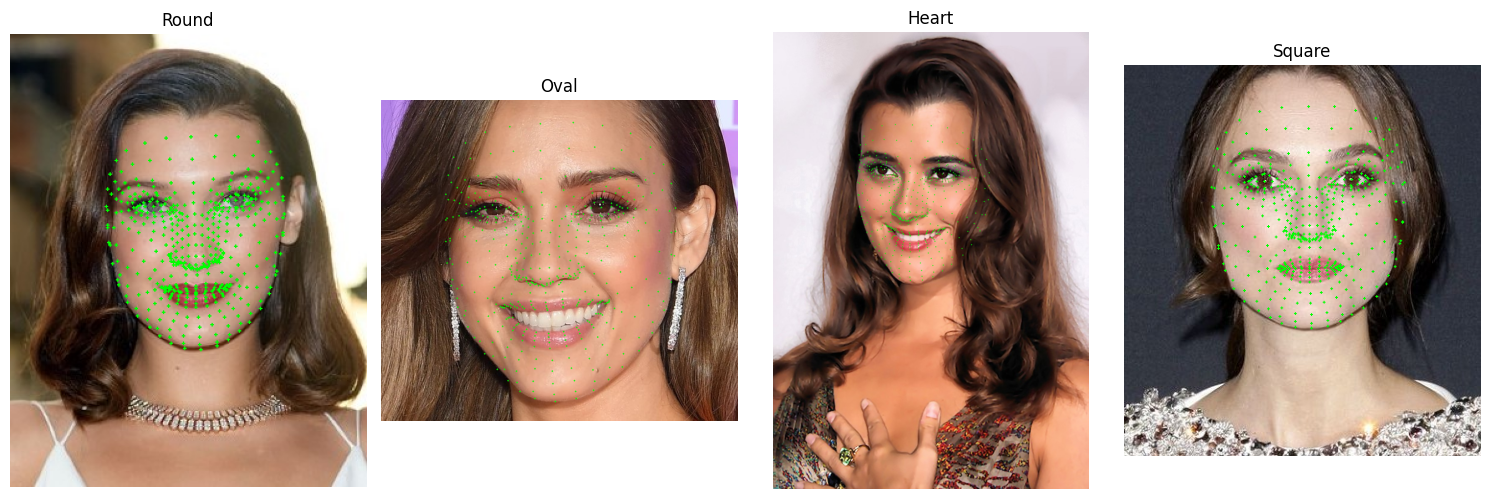

In [4]:
# ============================================================
# 4. Visualizar exemplos das classes com landmarks
# ============================================================
classes = os.listdir(data_path)
print("Classes encontradas:", classes)

plt.figure(figsize=(15, 5))

for i, emotion in enumerate(classes):
    emotion_path = os.path.join(data_path, emotion)
    random_img = random.choice(os.listdir(emotion_path))
    img_path = os.path.join(emotion_path, random_img)

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    coords = extract_landmarks(img_path)

    if coords is not None:
        h, w, _ = img_rgb.shape
        for (x, y, z) in coords:
            cx, cy = int(x * w), int(y * h)
            cv2.circle(img_rgb, (cx, cy), radius=1, color=(0, 255, 0), thickness=-1)
    else:
        print(f"Nenhum rosto detectado em: {random_img}")

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img_rgb)
    plt.title(emotion)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# ============================================================
# 6. Funções para cálculo de distâncias e razões geométricas
# ============================================================

# Dicionário com landmarks de interesse
landmark_indices = {
    10: 'Topo testa',
    152: 'Queixo',
    54: 'Testa esq',
    284: 'Testa dir',
    234: 'Maçã dir',
    454: 'Maçã esq',
    172: 'Maxilar dir',
    397: 'Maxilar esq',
    # 33: 'Olho esq ext',
    # 263: 'Olho dir ext',
    # 61: 'Boca esq',
    # 291: 'Boca dir'
}

Classes encontradas: ['Round', 'Oval', 'Heart', 'Square']


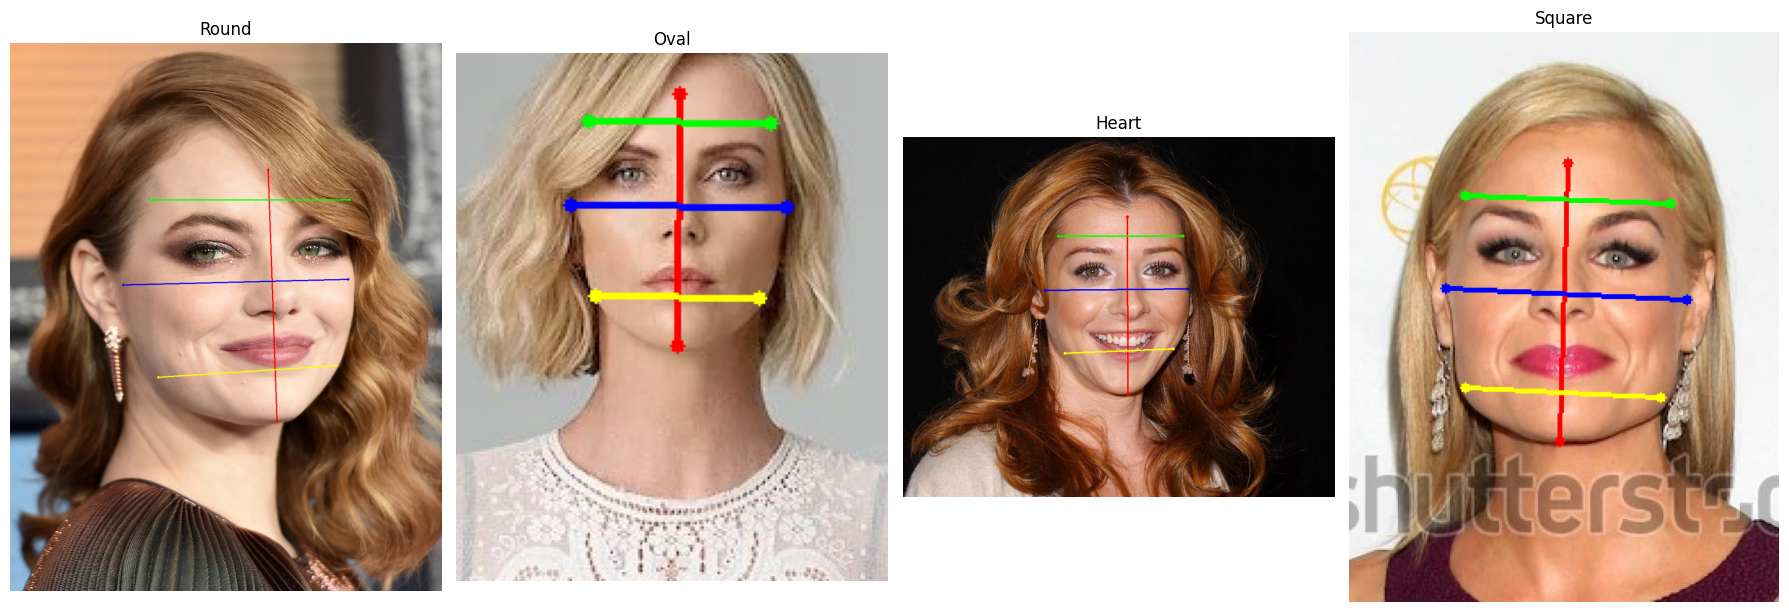

In [7]:
# Pares de pontos que formarão as retas das medidas geométricas
ligacoes = [
    (10, 152, (255, 0, 0)),     # Altura (🔴)
    (54, 284, (0, 255, 0)),     # Testa (🟢)
    (234, 454, (0, 0, 255)),    # Maçãs (🔵)
    (172, 397, (255, 255, 0))   # Maxilar (🟡)
]

# Lista das classes (pastas)
classes = os.listdir(data_path)
print("Classes encontradas:", classes)

plt.figure(figsize=(18, 6))

for i, classe in enumerate(classes):
    classe_path = os.path.join(data_path, classe)
    random_img = random.choice(os.listdir(classe_path))
    img_path = os.path.join(classe_path, random_img)

    imagem = cv2.imread(img_path)
    if imagem is None:
        print(f"⚠️ Erro ao carregar {img_path}")
        continue

    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

    # Extrai os landmarks da imagem
    coords = extract_landmarks(img_path)
    if coords is None:
        print(f"Nenhum rosto detectado em: {random_img}")
        continue

    h, w, _ = imagem_rgb.shape

    # Desenha os pontos e as ligações
    for (p1, p2, cor) in ligacoes:
        if p1 < len(coords) and p2 < len(coords):
            x1, y1, _ = coords[p1]
            x2, y2, _ = coords[p2]
            pt1, pt2 = (int(x1 * w), int(y1 * h)), (int(x2 * w), int(y2 * h))

            cv2.line(imagem_rgb, pt1, pt2, cor, 2)
            cv2.circle(imagem_rgb, pt1, 3, cor, -1)
            cv2.circle(imagem_rgb, pt2, 3, cor, -1)

    # Mostra a imagem com os pontos conectados
    plt.subplot(1, len(classes), i + 1)
    plt.imshow(imagem_rgb)
    plt.title(classe)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
# ------------------------------------------------------------
# Função auxiliar: distância euclidiana entre dois pontos 3D
# ------------------------------------------------------------
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

In [9]:
# ------------------------------------------------------------
# Função auxiliar: ângulo entre três pontos (em graus)
# ------------------------------------------------------------
def angle_between(p1, p2, p3):
    v1 = p1 - p2
    v2 = p3 - p2
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))
    return angle

In [10]:
# ------------------------------------------------------------
# Função: calcular distâncias principais
# ------------------------------------------------------------
def calcular_distancias(coords):
    # Pontos principais
    p10, p152 = coords[10], coords[152]
    p54, p284 = coords[54], coords[284]
    p234, p454 = coords[234], coords[454]
    p172, p397 = coords[172], coords[397]

    # Novos pontos
    #p33, p263 =oords[33], coords[263]     # olhos externos
    #p61, p291 = coords[61], coords[291]     # boca c

    # Distâncias básicas
    df = euclidean_distance(p54, p284)      # Forehead width
    dc = euclidean_distance(p454, p234)     # Cheekbone width
    dj = euclidean_distance(p397, p172)     # Jawline width
    dh = euclidean_distance(p10, p152)      # Facial height

    # Novas distâncias horizontais
    #eye_dist = euclidean_distance(p33, p263)  # distância entre olhos
    #mouth_width = euclidean_distance(p61, p291)  # largura da boca

    # Ângulo da mandíbula (esq → queixo → dir)
    #jaw_angle = angle_between(p397, p152, p172)

    return df, dc, dj, dh#, eye_dist, mouth_width, jaw_angle

In [13]:
# ------------------------------------------------------------
# Função: calcular razões derivadas das distâncias
# ------------------------------------------------------------
def calcular_razoes(df, dc, dj, dh):
    ratios = {
        "R1_height_to_cheekbone": dh / dc if dc != 0 else np.nan,
        "R2_jaw_to_forehead": dj / df if df != 0 else np.nan,
        "R3_jaw_to_cheekbone": dj / dc if dc != 0 else np.nan,
        "R4_forehead_to_cheekbone": df / dc if dc != 0 else np.nan,
        "R5_forehead_to_jaw": df / dj if dj != 0 else np.nan,
        # Novas razões horizontais
        #"R6_eye_to_cheekbone": eye_dist / dc if dc != 0 else np.nan,
        #"R7_mouth_to_jaw": mouth_width / dj if dj != 0 else np.nan,
        #"jaw_angle": jaw_angle
    }
    return ratios

In [15]:
# ============================================================
# 7. Construção do DataFrame com as features geométricas
# ============================================================
selected_classes = ['Heart', 'Oval', 'Round', 'Square']
data = []

for face_shape in selected_classes:
    class_path = os.path.join(data_path, face_shape)
    image_files = os.listdir(class_path)  # limitar a 500 imagens

    print(f"\nProcessando classe: {face_shape} ({len(image_files)} imagens)")

    for img_name in tqdm.tqdm(image_files, desc=f"{face_shape}", ncols=100):
        img_path = os.path.join(class_path, img_name)
        coords = extract_landmarks(img_path)

        if coords is None:
            continue

        df, dc, dj, dh = calcular_distancias(coords)
        ratios = calcular_razoes(df, dc, dj, dh)

        entry = {
            "face_shape": face_shape,
            "df": df,
            "dc": dc,
            "dj": dj,
            "dh": dh,
            #"eye_dist": eye_dist,
            #"mouth_width": mouth_width,
            #"jaw_angle": jaw_angle,
            **ratios
        }
        data.append(entry)


Processando classe: Heart (1000 imagens)


Heart: 100%|████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.91it/s]



Processando classe: Oval (1000 imagens)


Oval: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.84it/s]



Processando classe: Round (995 imagens)


Round: 100%|██████████████████████████████████████████████████████| 995/995 [00:50<00:00, 19.70it/s]



Processando classe: Square (1000 imagens)


Square: 100%|███████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.86it/s]


In [16]:
# ============================================================
# 8. Monta o DataFrame final
# ============================================================
df_features = pd.DataFrame(data)

# Mostra 3 exemplos de cada classe
print("\nExemplos de features extraídas (3 por classe):")
display(df_features.groupby("face_shape", group_keys=False).head(3))


Exemplos de features extraídas (3 por classe):


face_shape        df        dc        dj        dh  \
0         Heart  0.380268  0.453292  0.360879  0.391070   
1         Heart  0.441698  0.509827  0.400128  0.487481   
2         Heart  0.288978  0.338810  0.263589  0.307547   
1000       Oval  0.351557  0.411799  0.332984  0.356765   
1001       Oval  0.311319  0.352845  0.274799  0.433907   
1002       Oval  0.478488  0.544652  0.425734  0.457565   
2000      Round  0.340054  0.402781  0.326766  0.355452   
2001      Round  0.407172  0.470769  0.368175  0.406806   
2002      Round  0.337063  0.390252  0.304357  0.373586   
2995     Square  0.418975  0.501749  0.410284  0.483994   
2996     Square  0.504179  0.552479  0.432503  0.513210   
2997     Square  0.470750  0.534685  0.423552  0.487477   

      R1_height_to_cheekbone  R2_jaw_to_forehead  R3_jaw_to_cheekbone  \
0                   0.862733            0.949012             0.796129   
1                   0.956169            0.905886             0.784831   
2                   0.907725            0.912145             0.777985   
1000                0.866358            0.947171             0.808609   
1001                1.229738            0.882694             0.778810   
1002                0.840105            0.889748             0.781662   
2000                0.882494            0.960923             0.811275   
2001                0.864132            0.904226             0.782072   
2002                0.957294            0.902967             0.779898   
2995                0.964614            0.979257             0.817707   
2996                0.928922            0.857835             0.782839   
2997                0.911710            0.899738             0.792153   

      R4_forehead_to_cheekbone  R5_forehead_to_jaw  
0                     0.838903            1.053727  
1                     0.866369            1.103892  
2                     0.852918            1.096318  
1000                  0.853710            1.055776  
1001                  0.882310            1.132895  
1002                  0.878520            1.123913  
2000                  0.844267            1.040666  
2001                  0.864908            1.105918  
2002                  0.863706            1.107460  
2995                  0.835028            1.021182  
2996                  0.912576            1.165725  
2997                  0.880426            1.111434

In [17]:
# ============================================================
# 9. Verifica estatísticas básicas por classe
# ============================================================
print("\nDistribuição por classe:")
print(df_features["face_shape"].value_counts())

print("\nEstatísticas descritivas das features:")
display(df_features.describe().T)


Distribuição por classe:
face_shape
Heart     1000
Oval      1000
Square    1000
Round      995
Name: count, dtype: int64

Estatísticas descritivas das features:


count      mean       std       min       25%  \
df                        3995.0  0.416190  0.073053  0.126226  0.368651   
dc                        3995.0  0.479727  0.082292  0.146648  0.425891   
dj                        3995.0  0.378499  0.065514  0.116379  0.333908   
dh                        3995.0  0.465336  0.094812  0.234039  0.405658   
R1_height_to_cheekbone    3995.0  0.976183  0.155124  0.632043  0.884741   
R2_jaw_to_forehead        3995.0  0.910583  0.040582  0.760067  0.882450   
R3_jaw_to_cheekbone       3995.0  0.788957  0.019025  0.717869  0.775592   
R4_forehead_to_cheekbone  3995.0  0.867313  0.021697  0.802142  0.852263   
R5_forehead_to_jaw        3995.0  1.100396  0.049447  0.955938  1.064976   

                               50%       75%       max  
df                        0.420636  0.463064  0.790298  
dc                        0.485802  0.532709  0.888989  
dj                        0.383727  0.421514  0.692212  
dh                        0.459811  0.510365  1.053336  
R1_height_to_cheekbone    0.944162  1.021263  2.168650  
R2_jaw_to_forehead        0.911132  0.938989  1.046093  
R3_jaw_to_cheekbone       0.789595  0.802734  0.854525  
R4_forehead_to_cheekbone  0.866460  0.881851  0.974131  
R5_forehead_to_jaw        1.097536  1.133209  1.315674

In [18]:
def classificar_formato_rosto(r1, r2, r3, r4, r5, tol=0.08):
    """
    Classifica o formato do rosto com base em razões geométricas simples.
    """

    # Heart — testa larga, mandíbula estreita
    if r1 > 0.95 and r2 < 0.9 and r3 < 0.85 and r5 > 1.1:
        return "Heart"

    # Oval — proporções equilibradas, levemente alongado
    if 0.9 <= r1 <= 1.1 and 0.85 <= r2 <= 0.95 and 0.75 <= r3 <= 0.85 and 1.05 <= r5 <= 1.12:
        return "Oval"

    # Round — quase simétrico, mas bochechas salientes
    if abs(r1 - 1.0) <= tol and abs(r4 - 0.9) <= tol and 1.1 <= r5 <= 1.2:
        return "Round"

    # Square — mandíbula e testa largas
    if r1 < 0.9 and 0.9 <= r2 <= 0.97 and 0.8 <= r3 <= 0.85 and r5 < 1.1:
        return "Square"

    # Caso indefinido
    return "Indefinido"


In [19]:
# Aplica a função de classificação a cada linha
df_features["predicted_shape"] = df_features.apply(
    lambda row: classificar_formato_rosto(row["R1_height_to_cheekbone"], row["R2_jaw_to_forehead"], row["R3_jaw_to_cheekbone"], row["R4_forehead_to_cheekbone"], row["R5_forehead_to_jaw"]),
    axis=1
)

In [20]:
acc = accuracy_score(df_features["face_shape"], df_features["predicted_shape"])
print(f"\nAcurácia das regras geométricas: {acc:.2%}")

print("\nRelatório de classificação:")
print(classification_report(df_features["face_shape"], df_features["predicted_shape"]))


Acurácia das regras geométricas: 20.25%

Relatório de classificação:
              precision    recall  f1-score   support

       Heart       0.42      0.36      0.39      1000
  Indefinido       0.00      0.00      0.00         0
        Oval       0.27      0.26      0.27      1000
       Round       0.21      0.04      0.06       995
      Square       0.49      0.15      0.24      1000

    accuracy                           0.20      3995
   macro avg       0.28      0.16      0.19      3995
weighted avg       0.35      0.20      0.24      3995



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


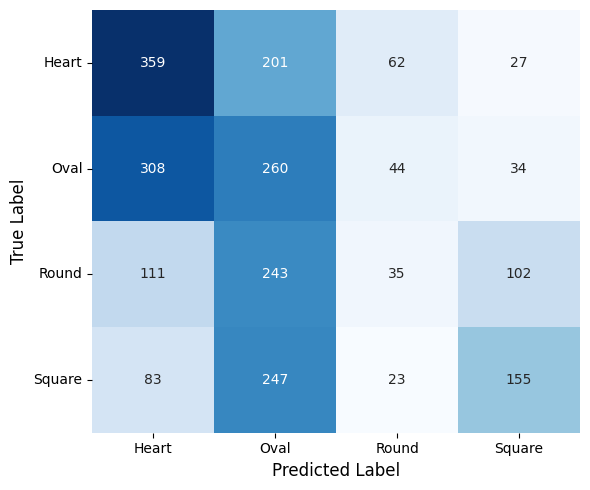

In [31]:
# Compute confusion matrix
cm = confusion_matrix(df_features["face_shape"],
                      df_features["predicted_shape"],
                      labels=selected_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=selected_classes,
    yticklabels=selected_classes,
    cbar=False
)

# Titles and labels in English
#plt.title("Confusion Matrix – Threshold-Based Classification", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Tick label size
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

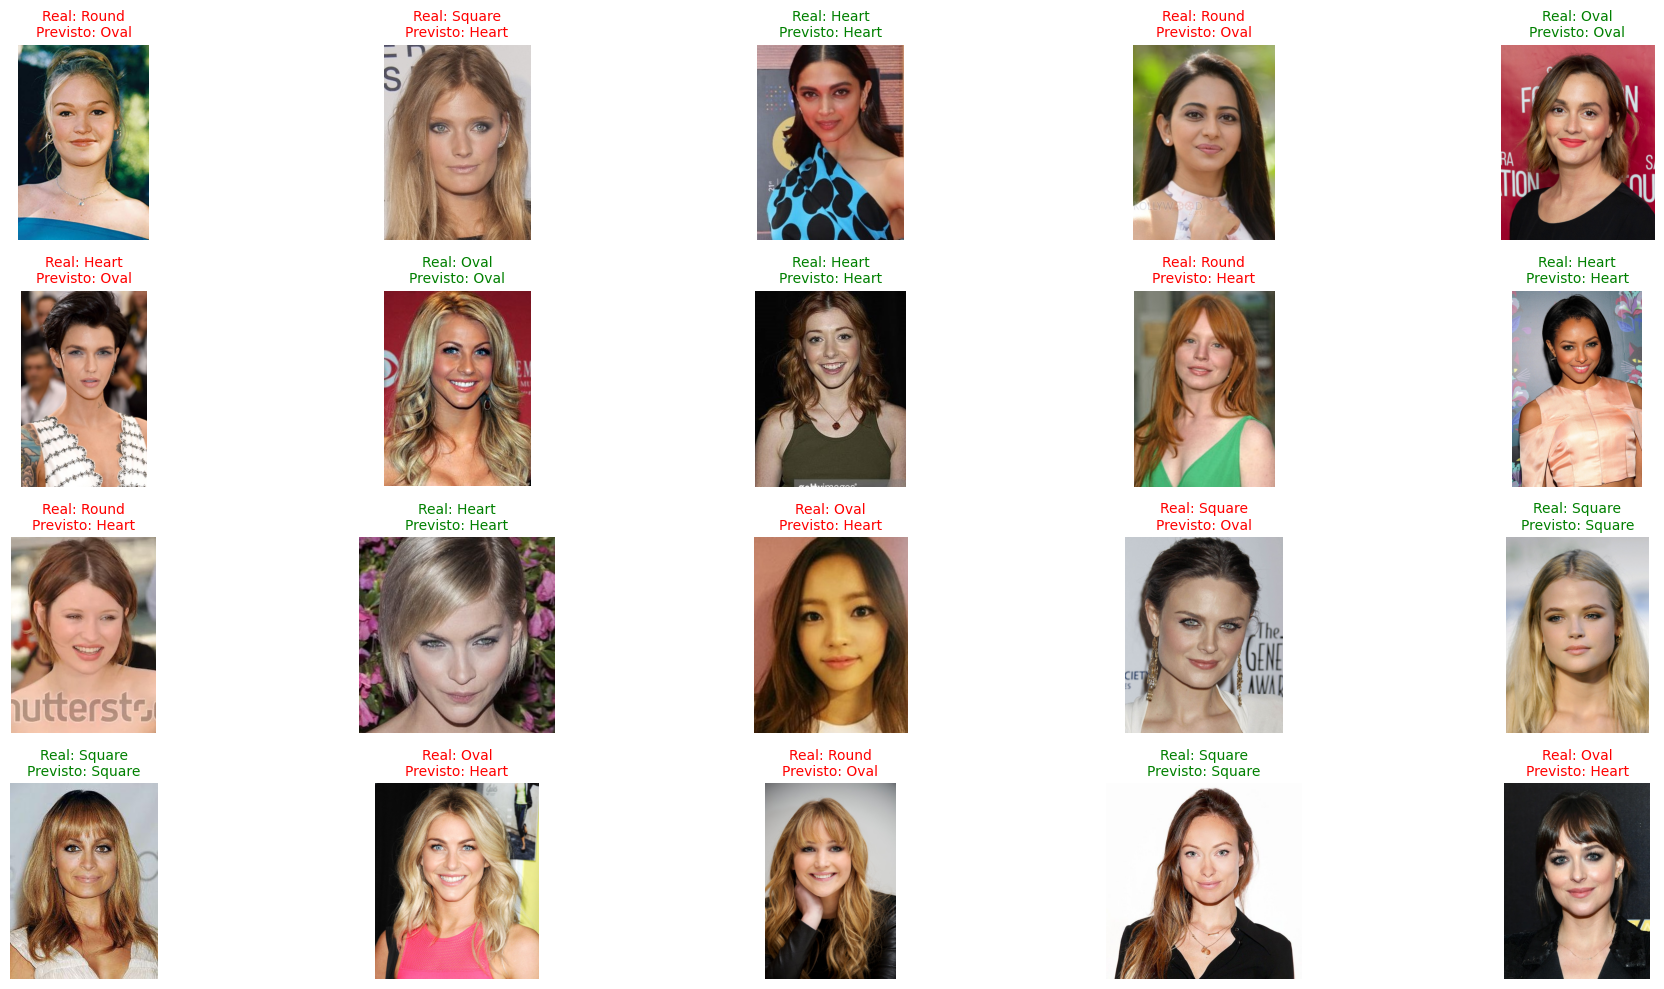

In [ ]:
# ============================================================
# 13. Exibição de 20 imagens com seus rótulos reais e previstos
# ============================================================
df_validas = df_features[df_features["predicted_shape"] != "Indefinido"]

# Selecionar amostra de 20 imagens
amostra = df_validas.sample(20, random_state=42).reset_index(drop=True)

# Criar o painel
plt.figure(figsize=(20, 10))
for i, row in amostra.iterrows():
    face_shape = row["face_shape"]
    predicted = row["predicted_shape"]

    # Caminho da imagem correspondente
    class_path = os.path.join(data_path, face_shape)
    image_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, image_name)

    # Ler e mostrar imagem
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 5, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Real: {face_shape}\nPrevisto: {predicted}",
              fontsize=10, color=("green" if face_shape == predicted else "red"))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [23]:
# ============================================================
# 1. Preparação dos dados para o modelo
# ============================================================

# Mantém apenas linhas com classes válidas
df_model = df_features[df_features["face_shape"].isin(selected_classes)].copy()

# Features e rótulo
X = df_model[["df", "dc", "dj", "dh", "R1_height_to_cheekbone",
              "R2_jaw_to_forehead", "R3_jaw_to_cheekbone",
              "R4_forehead_to_cheekbone", "R5_forehead_to_jaw"]]

y = df_model["face_shape"]

print("Formato das features:", X.shape)


Formato das features: (3995, 9)


In [24]:
# Codifica os rótulos (de texto → numérico)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Divide os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Normaliza as features (fundamental para redes neurais)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Treino: {X_train_scaled.shape}, Teste: {X_test_scaled.shape}")

Treino: (3196, 9), Teste: (799, 9)


🎯 Random Forest - Acurácia: 0.4643

              precision    recall  f1-score   support

       Heart       0.44      0.49      0.46       200
        Oval       0.40      0.32      0.35       200
       Round       0.39      0.36      0.37       199
      Square       0.59      0.69      0.64       200

    accuracy                           0.46       799
   macro avg       0.45      0.46      0.46       799
weighted avg       0.45      0.46      0.46       799



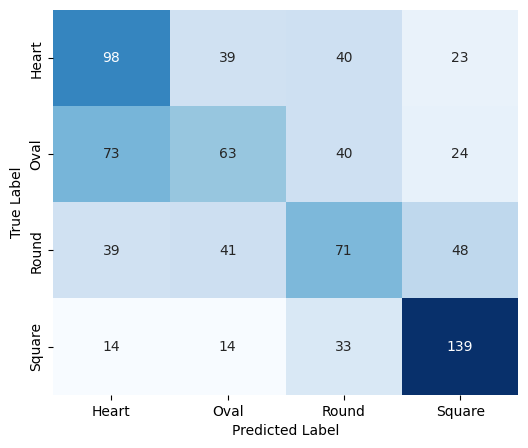

In [40]:
# -----------------------
# 1️⃣ Random Forest
# -----------------------
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"🎯 Random Forest - Acurácia: {rf_acc:.4f}\n")
print(classification_report(y_test, rf_pred, target_names=encoder.classes_))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt="d",
            cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_,
    cbar=False)
#plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
import joblib

# Salva o modelo treinado
joblib.dump(rf_model, "rf_model.pkl")

# Salva o encoder
joblib.dump(encoder, "label_encoder.pkl")

# Salva o scaler
joblib.dump(scaler, "scaler.pkl")

print("Arquivos salvos com sucesso!")


Arquivos salvos com sucesso!


🎯 Gradient Boosting - Acurácia: 0.4531

              precision    recall  f1-score   support

       Heart       0.41      0.46      0.43       200
        Oval       0.45      0.34      0.39       200
       Round       0.37      0.36      0.36       199
      Square       0.57      0.66      0.61       200

    accuracy                           0.45       799
   macro avg       0.45      0.45      0.45       799
weighted avg       0.45      0.45      0.45       799



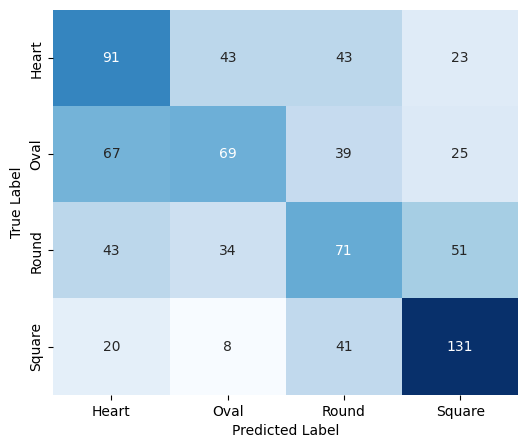

In [41]:
# -----------------------
# 2️⃣ Gradient Boosting
# -----------------------
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

gb_pred = gb_model.predict(X_test_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"🎯 Gradient Boosting - Acurácia: {gb_acc:.4f}\n")
print(classification_report(y_test, gb_pred, target_names=encoder.classes_))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, gb_pred), annot=True, fmt="d",
            cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_,
    cbar=False)
#plt.title("Matriz de Confusão - Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])


model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=80,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3121 - loss: 1.3893 - val_accuracy: 0.3550 - val_loss: 1.3434 - learning_rate: 5.0000e-04
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3622 - loss: 1.3440 - val_accuracy: 0.3800 - val_loss: 1.3134 - learning_rate: 5.0000e-04
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3615 - loss: 1.3233 - val_accuracy: 0.3900 - val_loss: 1.2888 - learning_rate: 5.0000e-04
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3774 - loss: 1.2948 - val_accuracy: 0.3925 - val_loss: 1.2690 - learning_rate: 5.0000e-04
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3926 - loss: 1.2724 - val_accuracy: 0.4000 - val_loss: 1.2534 - learning_rate: 5.0000e-04
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3951 - loss: 1.2628 - val_accuracy: 0.4100 - val_loss: 1.2401 - learning_rate: 5.0000e-04
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4066 - lo

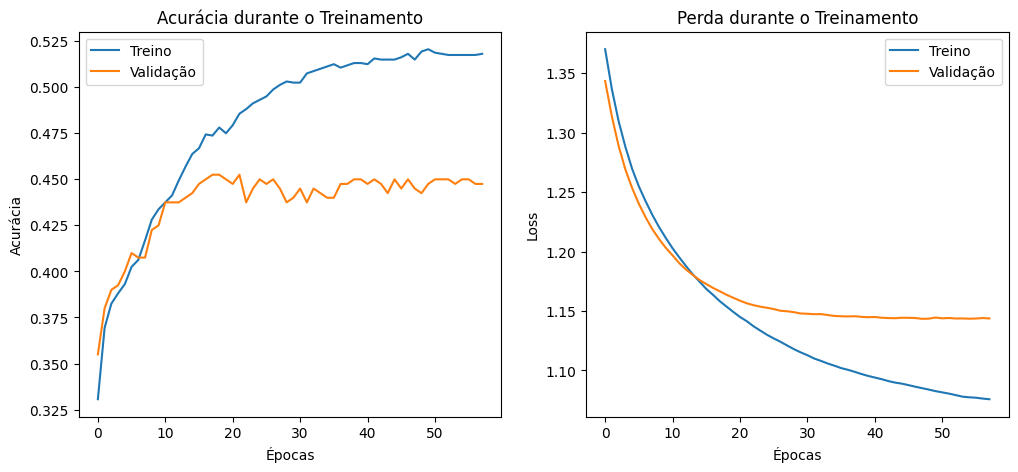

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def preprocess_image(image_path, size=(64, 64)):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, size)
    img_normalized = img_resized / 255.0
    return img_normalized

In [ ]:
selected_classes = ['Heart', 'Oval', 'Round', 'Square']
images, labels = [], []

for label, face_shape in enumerate(selected_classes):
    class_path = os.path.join(data_path, face_shape)
    image_files = os.listdir(class_path)
    print(f"Processando {face_shape} ({len(image_files)} imagens)")

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        img_array = preprocess_image(img_path)
        if img_array is None:
            continue
        images.append(img_array)
        labels.append(label)

X = np.array(images, dtype=np.float32)
y = np.array(labels, dtype=np.int32)
print(f"Formato final das imagens: {X.shape}, Labels: {y.shape}")

Processando Heart (1000 imagens)
Processando Oval (1000 imagens)
Processando Round (995 imagens)
Processando Square (1000 imagens)
Formato final das imagens: (3995, 64, 64, 3), Labels: (3995,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (2796, 64, 64, 3), Teste: (1199, 64, 64, 3)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
# Número de classes
num_classes = len(selected_classes)

# ============================================================
# 1. Criar modelo CNN simples
# ============================================================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# ============================================================
# 2. Compilar modelo
# ============================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,612 (2.61 MB)

 Trainable params: 684,164 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# ============================================================
# Treinamento usando data augmentation
# ============================================================
history = model.fit(
    X_train, y_train, batch_size=32,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 517ms/step - accuracy: 0.2804 - loss: 1.5252 - val_accuracy: 0.2977 - val_loss: 1.3833 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 319ms/step - accuracy: 0.3771 - loss: 1.3200 - val_accuracy: 0.3294 - val_loss: 1.3695 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 324ms/step - accuracy: 0.4039 - loss: 1.2692 - val_accuracy: 0.4128 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 328ms/step - accuracy: 0.4574 - loss: 1.1975 - val_accuracy: 0.3786 - val_loss: 1.3073 - learning_rate: 0.0010
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.4961 - loss: 1.1389 - val_accuracy: 0.4312 - val_loss: 1.2839 - learning_rate: 0.0010
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/step - accuracy: 0.4772 - loss: 1.1310 - val_accuracy: 0.4254 - val_loss: 1.3122 - learning_rate: 0.0010
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 334ms/step - accuracy: 0.5221 - loss: 1.

In [ ]:
# Avaliar no teste
loss, acc = model.evaluate(X_test, y_test)
print(f"Acurácia no teste: {acc:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4377 - loss: 1.2964
Acurácia no teste: 0.4312


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step


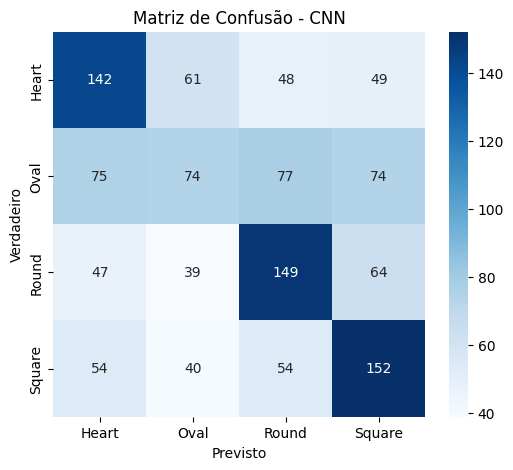

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=selected_classes, yticklabels=selected_classes, cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - CNN")
plt.show()

In [ ]:
# -----------------------------
# Parâmetros
# -----------------------------
selected_classes = ['Heart', 'Oval', 'Round', 'Square']
image_size = (64, 64)
max_images_per_class = 500  # limita por classe

# -----------------------------
# Inicializa listas
# -----------------------------
images = []
geom_features = []
labels = []

# -----------------------------
# Loop pelas classes
# -----------------------------
for label, face_shape in enumerate(selected_classes):
    class_path = os.path.join(data_path, face_shape)
    image_files = os.listdir(class_path)[:max_images_per_class]

    print(f"\nProcessando classe: {face_shape} ({len(image_files)} imagens)")

    for img_name in tqdm.tqdm(image_files, desc=face_shape, ncols=100):
        img_path = os.path.join(class_path, img_name)

        # --- 1. Processa imagem ---
        img_array = preprocess_image(img_path, size=image_size)
        if img_array is None:
            continue

        # --- 2. Extrai landmarks e calcula features geométricas ---
        coords = extract_landmarks(img_path)
        if coords is None:
            continue

        # Atualize essa função para retornar suas features extras: eye_dist, mouth_width, jaw_angle, etc.
        df, dc, dj, dh, eye_dist, mouth_width, jaw_angle = calcular_distancias(coords)
        ratios = calcular_razoes(df, dc, dj, dh, eye_dist, mouth_width, jaw_angle)

        geom_array = np.array([
            df, dc, dj, dh, eye_dist, mouth_width, jaw_angle,
            ratios["R1_height_to_cheekbone"],
            ratios["R2_jaw_to_forehead"],
            ratios["R3_jaw_to_cheekbone"],
            ratios["R4_forehead_to_cheekbone"],
            ratios["R5_forehead_to_jaw"]
        ], dtype=np.float32)

        # --- 3. Armazena nos arrays ---
        images.append(img_array)
        geom_features.append(geom_array)
        labels.append(label)

# -----------------------------
# Converte para arrays numpy
# -----------------------------
X_images = np.array(images, dtype=np.float32)
X_geom = np.array(geom_features, dtype=np.float32)
y = np.array(labels, dtype=np.int32)

print(f"Imagens: {X_images.shape}, Features geométricas: {X_geom.shape}, Labels: {y.shape}")


Processando classe: Heart (500 imagens)


Heart: 100%|██████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.78it/s]



Processando classe: Oval (500 imagens)


Oval: 100%|███████████████████████████████████████████████████████| 500/500 [00:32<00:00, 15.38it/s]



Processando classe: Round (500 imagens)


Round: 100%|██████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.99it/s]



Processando classe: Square (500 imagens)


Square: 100%|█████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.45it/s]

Imagens: (2000, 64, 64, 3), Features geométricas: (2000, 12), Labels: (2000,)


In [ ]:
 #-----------------------------
# Normaliza features geométricas
# -----------------------------
scaler = StandardScaler()
X_geom_scaled = scaler.fit_transform(X_geom)

# -----------------------------
# Divide treino/teste
# -----------------------------
X_train_img, X_test_img, X_train_geom, X_test_geom, y_train, y_test = train_test_split(
    X_images, X_geom_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: Imagens {X_train_img.shape}, Features {X_train_geom.shape}, Teste: Imagens {X_test_img.shape}, Features {X_test_geom.shape}")


Treino: Imagens (1600, 64, 64, 3), Features (1600, 12), Teste: Imagens (400, 64, 64, 3), Features (400, 12)


In [ ]:
# ============================================================
# 1. Inputs
# ============================================================
# Input para imagens
input_img = Input(shape=(X_train_img.shape[1], X_train_img.shape[2], X_train_img.shape[3]), name='image_input')

x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Input para features geométricas
input_geom = Input(shape=(X_train_geom.shape[1],), name='geom_input')
y = Dense(64, activation='relu')(input_geom)
y = Dropout(0.2)(y)
y = Dense(32, activation='relu')(y)

# Combina as duas branches
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(len(selected_classes), activation='softmax')(z)

# ============================================================
# 2. Modelo final
# ============================================================
model = Model(inputs=[input_img, input_geom], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 128) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geom_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │        832 │ geom_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │  1,048,704 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0

 Total params: 1,156,324 (4.41 MB)

 Trainable params: 1,155,876 (4.41 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# ============================================================
# 3. Callbacks
# ============================================================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# ============================================================
# 4. Treino
# ============================================================
history = model.fit(
    [X_train_img, X_train_geom], y_train,
    validation_data=([X_test_img, X_test_geom], y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 395ms/step - accuracy: 0.2833 - loss: 1.7738 - val_accuracy: 0.2700 - val_loss: 1.3766 - learning_rate: 5.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.3655 - loss: 1.3906 - val_accuracy: 0.3950 - val_loss: 1.3501 - learning_rate: 5.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - accuracy: 0.4321 - loss: 1.2753 - val_accuracy: 0.3225 - val_loss: 1.3348 - learning_rate: 5.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - accuracy: 0.4757 - loss: 1.2114 - val_accuracy: 0.3900 - val_loss: 1.3165 - learning_rate: 5.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step - accuracy: 0.5441 - loss: 1.0648 - val_accuracy: 0.4375 - val_loss: 1.2808 - learning_rate: 5.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 0.5948 - loss: 0.9747 - val_accuracy: 0.4275 - val_loss: 1.2061 - learning_rate: 5.0000e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - acc

In [ ]:
test_loss, test_acc = model.evaluate([X_test_img, X_test_geom], y_test, verbose=1)
print(f"\nAcurácia no teste: {test_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5019 - loss: 1.1641

Acurácia no teste: 0.5025


In [ ]:
# ============================================================
# A. Extrair 468 landmarks (x,y,z) e salvar dataset
# ============================================================

# Variáveis que assumo já existirem no seu notebook:
# - data_path (pasta com subpastas Heart,Oval,Round,Square)
# - face_mesh (instância mp.solutions.face_mesh.FaceMesh já criada)
# - extract_landmarks(image_path) -> retorna coords (468 x 3) ou None

selected_classes = ['Heart', 'Oval', 'Round', 'Square']
max_images_per_class = None  # None ou número para limitar por classe (ex: 1000)

rows = []
failed = 0
total = 0

for face_shape in selected_classes:
    class_path = os.path.join(data_path, face_shape)
    image_files = sorted(os.listdir(class_path))
    if max_images_per_class:
        image_files = image_files[:max_images_per_class]
    print(f"Processando classe {face_shape}: {len(image_files)} arquivos")

    for img_name in tqdm.tqdm(image_files, desc=face_shape, ncols=100):
        total += 1
        img_path = os.path.join(class_path, img_name)
        coords = extract_landmarks(img_path)
        if coords is None:
            failed += 1
            continue
        # coords shape: (468,3) -> flatten
        flat = coords.reshape(-1)  # length 468*3 = 1404
        row = {"face_shape": face_shape, "image": img_name}
        # Nomeia colunas: lm0_x lm0_y lm0_z ... lm467_z
        for i in range(468):
            row[f"lm{i}_x"] = float(coords[i,0])
            row[f"lm{i}_y"] = float(coords[i,1])
            row[f"lm{i}_z"] = float(coords[i,2])
        rows.append(row)

print(f"\nTotal processado: {total}, sem landmarks: {failed}, com landmarks: {len(rows)}")

# Monta DataFrame (pode ser grande)
df_landmarks = pd.DataFrame(rows)
print("DataFrame montado:", df_landmarks.shape)

# Salva em disco para não recalcular
out_dir = "/content/drive/MyDrive/face_shape_landmarks"  # ajuste se quiser
os.makedirs(out_dir, exist_ok=True)
csv_path = os.path.join(out_dir, "landmarks_468_all.csv")
npz_path = os.path.join(out_dir, "landmarks_468_all.npz")

df_landmarks.to_csv(csv_path, index=False)
# Também salvo arrays numpy (labels + features) para uso direto
labels = df_landmarks["face_shape"].values
images_names = df_landmarks["image"].values
features = df_landmarks.drop(columns=["face_shape", "image"]).values.astype(np.float32)
np.savez_compressed(npz_path, X=features, y=labels, image_names=images_names)

print("Salvo:", csv_path, npz_path)


Processando classe Heart: 1000 arquivos


Heart: 100%|████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.22it/s]


Processando classe Oval: 1000 arquivos


Oval: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.56it/s]


Processando classe Round: 995 arquivos


Round: 100%|██████████████████████████████████████████████████████| 995/995 [00:44<00:00, 22.56it/s]


Processando classe Square: 1000 arquivos


Square: 100%|███████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.79it/s]



Total processado: 3995, sem landmarks: 0, com landmarks: 3995
DataFrame montado: (3995, 1406)
Salvo: /content/drive/MyDrive/face_shape_landmarks/landmarks_468_all.csv /content/drive/MyDrive/face_shape_landmarks/landmarks_468_all.npz


X shape: (3995, 1404) n samples: 3995


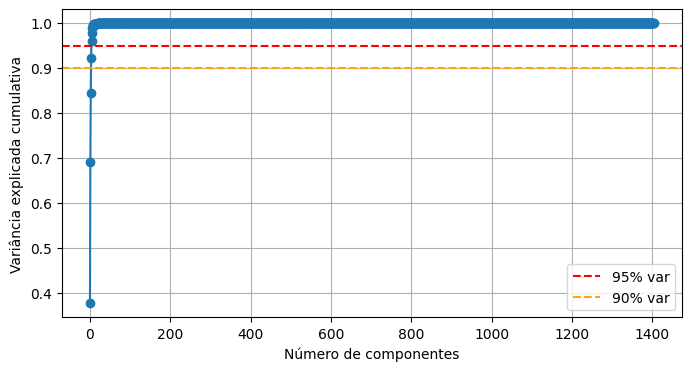

Componentes para 95% var: 5
X_pca_n shape: (3995, 5)
PCA e scaler salvos.


In [ ]:
# ============================================================
# B. PCA sobre todos os 468*3 = 1404 recursos
# ============================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Carrega o .npz salvo (ou use X, y do ambiente)
npz = np.load(npz_path, allow_pickle=True)
X = npz["X"]         # shape (n_samples, 1404)
y = npz["y"]         # labels strings
image_names = npz["image_names"]

print("X shape:", X.shape, "n samples:", X.shape[0])

# Padroniza
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA completo (calcula todas as components)
pca = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1]), svd_solver='auto', random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot da variância explicada cumulativa
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,4))
plt.plot(explained, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Variância explicada cumulativa")
plt.grid(True)
plt.axhline(0.95, color='red', linestyle='--', label='95% var')
plt.axhline(0.90, color='orange', linestyle='--', label='90% var')
plt.legend()
plt.show()

# Escolher n_components para 95% de variância
n95 = int(np.searchsorted(explained, 0.95) + 1)
print("Componentes para 95% var:", n95)

# Transformar para n componentes (exemplo: 95% var)
pca_n = PCA(n_components=n95, random_state=42)
X_pca_n = pca_n.fit_transform(X_scaled)
print("X_pca_n shape:", X_pca_n.shape)

# Salvar PCA e scaler para uso futuro
import joblib
joblib.dump(pca_n, os.path.join(out_dir, "pca_n.pkl"))
joblib.dump(scaler, os.path.join(out_dir, "scaler.pkl"))
print("PCA e scaler salvos.")


In [ ]:
# ============================================================
# C. Algoritmo Genético simples para seleção de features
# ============================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import random
import time

# Parâmetros do GA (ajuste para mais/menos tempo)
POP_SIZE = 20
N_GEN = 30
TOURN_SIZE = 3
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.02  # por gene

n_features = X.shape[1]
print("Número original de features:", n_features)

# Pré-calc: transforme labels categóricos para inteiros
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Fitness: retorna 1 - mean(cv_score) para minimizar, ou simplesmente mean(cv_score)
def fitness_of(chromosome):
    # chromosome: boolean array shape (n_features,)
    # Se todos zeros, penaliza
    if chromosome.sum() == 0:
        return 0.0
    selected_idx = np.where(chromosome == 1)[0]
    X_sel = X_scaled[:, selected_idx]  # usa dados padronizados
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # Use cross_val_score para estabilidade
    scores = cross_val_score(clf, X_sel, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
    return float(scores.mean())

# Inicializa população (random bits)
def init_population(pop_size, n_features, init_rate=0.05):
    pop = []
    for _ in range(pop_size):
        # inicializa com poucas features por indivíduo
        chrom = (np.random.rand(n_features) < init_rate).astype(np.int8)
        # garante pelo menos 1 feature
        if chrom.sum() == 0:
            chrom[np.random.randint(0, n_features)] = 1
        pop.append(chrom)
    return pop

# Torneio
def tournament_selection(pop, scores, k=3):
    selected = random.sample(range(len(pop)), k)
    best = max(selected, key=lambda i: scores[i])
    return pop[best].copy()

# Crossover (one-point)
def crossover(a, b):
    if random.random() > CROSSOVER_RATE:
        return a.copy(), b.copy()
    pt = random.randint(1, n_features-1)
    child1 = np.concatenate([a[:pt], b[pt:]])
    child2 = np.concatenate([b[:pt], a[pt:]])
    return child1.astype(np.int8), child2.astype(np.int8)

# Mutation (flip bits)
def mutate(chrom):
    for i in range(n_features):
        if random.random() < MUTATION_RATE:
            chrom[i] = 1 - chrom[i]
    # garante ao menos 1 gene ativo
    if chrom.sum() == 0:
        chrom[random.randint(0, n_features-1)] = 1
    return chrom

# GA loop
random.seed(42)
pop = init_population(POP_SIZE, n_features, init_rate=0.02)
best_solution = None
best_score = 0.0
history_ga = []

start_time = time.time()
for gen in range(N_GEN):
    # Avalia população
    scores = []
    for ind in pop:
        scores.append(fitness_of(ind))
    scores = np.array(scores)
    gen_best_idx = np.argmax(scores)
    gen_best_score = scores[gen_best_idx]
    gen_best_ind = pop[gen_best_idx].copy()
    history_ga.append(gen_best_score)
    if gen_best_score > best_score:
        best_score = gen_best_score
        best_solution = gen_best_ind.copy()
    print(f"Gen {gen+1}/{N_GEN} - best_score: {gen_best_score:.4f} - global_best: {best_score:.4f}")

    # Novo tamanho da população por reprodução elitista simples
    new_pop = []
    # Keep elite
    elite_idx = np.argsort(scores)[-2:] if POP_SIZE>=2 else [gen_best_idx]
    for idx in elite_idx:
        new_pop.append(pop[idx].copy())

    # Gera novos filhos até completar
    while len(new_pop) < POP_SIZE:
        p1 = tournament_selection(pop, scores, k=TOURN_SIZE)
        p2 = tournament_selection(pop, scores, k=TOURN_SIZE)
        c1, c2 = crossover(p1, p2)
        c1 = mutate(c1)
        c2 = mutate(c2)
        new_pop.append(c1)
        if len(new_pop) < POP_SIZE:
            new_pop.append(c2)
    pop = new_pop

elapsed = time.time() - start_time
print(f"GA terminado em {elapsed/60:.2f} min. Best score: {best_score:.4f}")

# Features selecionadas
selected_idx = np.where(best_solution == 1)[0]
print("Número de features selecionadas pelo GA:", len(selected_idx))

# Treina um classificador final nas features selecionadas e avalia no CV (ou separa um teste se quiser)
if len(selected_idx) > 0:
    X_sel = X_scaled[:, selected_idx]
    clf_final = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    final_scores = cross_val_score(clf_final, X_sel, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
    print("CV accuracy (5-fold) com features GA:", final_scores.mean(), final_scores)
else:
    print("GA não selecionou features válidas.")


Número original de features: 1404
Gen 1/30 - best_score: 0.4488 - global_best: 0.4488
Gen 2/30 - best_score: 0.4543 - global_best: 0.4543
Gen 3/30 - best_score: 0.4543 - global_best: 0.4543
Gen 4/30 - best_score: 0.4583 - global_best: 0.4583
Gen 5/30 - best_score: 0.4633 - global_best: 0.4633
Gen 6/30 - best_score: 0.4641 - global_best: 0.4641
Gen 7/30 - best_score: 0.4641 - global_best: 0.4641
Gen 8/30 - best_score: 0.4641 - global_best: 0.4641
Gen 9/30 - best_score: 0.4641 - global_best: 0.4641
Gen 10/30 - best_score: 0.4641 - global_best: 0.4641
Gen 11/30 - best_score: 0.4641 - global_best: 0.4641
Gen 12/30 - best_score: 0.4641 - global_best: 0.4641
Gen 13/30 - best_score: 0.4651 - global_best: 0.4651
Gen 14/30 - best_score: 0.4651 - global_best: 0.4651
Gen 15/30 - best_score: 0.4651 - global_best: 0.4651
Gen 16/30 - best_score: 0.4651 - global_best: 0.4651
Gen 17/30 - best_score: 0.4651 - global_best: 0.4651
Gen 18/30 - best_score: 0.4651 - global_best: 0.4651
Gen 19/30 - best_scor